In [1]:
!pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 8.8 MB/s eta 0:00:00


# Imports

In [2]:
import os
import json
import numpy as np
import cv2
import torch
import torch.optim as optim
from segment_anything import sam_model_registry, SamPredictor
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import pycocotools.mask as maskUtils
import matplotlib.pyplot as plt
from skimage.draw import polygon
from functools import singledispatch
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tqdm import tqdm
import torch.nn.functional as F

# Config

In [3]:
CHECKPOINT_PATH = '/kaggle/input/sam/other/default/1/sam_vit_l_0b3195.pth'
TRAIN_IMAGES_PATH = '/kaggle/input/underwaterimageinstancesegmentation/UIIS/UDW/train'
TRAIN_ANNOTATIONS_PATH = '/kaggle/input/underwaterimageinstancesegmentation/UIIS/UDW/annotations/train.json'
VAL_IMAGES_PATH = '/kaggle/input/underwaterimageinstancesegmentation/UIIS/UDW/val'
VAL_ANNOTATIONS_PATH = '/kaggle/input/underwaterimageinstancesegmentation/UIIS/UDW/annotations/val.json'
EPOCHS = 5

@singledispatch
def to_serializable(val):
    """Used by default."""
    return str(val)

@to_serializable.register(np.float32)
def ts_float32(val):
    """Used if *val* is an instance of numpy.float32."""
    return float(val)

@to_serializable.register(np.float64)
def ts_float64(val):
    """Used if *val* is an instance of numpy.float64."""
    return float(val)

# Visualize methods

In [4]:
def visualize_sample(image_rgb, gt_mask_combined, mask):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image_rgb)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask_combined, cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

# Training Loop

## Load Model

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sam = sam_model_registry["vit_l"](checkpoint=CHECKPOINT_PATH)
for block in sam.image_encoder.blocks:
    block.use_checkpoint = True
sam.to(device)
optimizer = optim.Adam(sam.mask_decoder.parameters(), lr=0.001)
scaler = torch.cuda.amp.GradScaler()

/opt/conda/lib/python3.10/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)
/tmp/ipykernel_23/3170748

# Calculate mean IOU

In [6]:
def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    return np.sum(intersection) / np.sum(union)

## Training in play

In [7]:
print("Starting training...")
with open(TRAIN_ANNOTATIONS_PATH) as f:
    train_data = json.load(f)
coco_train = COCO(TRAIN_ANNOTATIONS_PATH)

best_loss = float('inf')
best_model_path = 'best_sam_model.pth'

for epoch in range(EPOCHS):
    total_loss = 0
    pbar = tqdm(enumerate(train_data['images']), total=len(train_data['images']), desc=f'Epoch {epoch+1}/{EPOCHS}')
    for img_idx, img_info in pbar:
        # Clear memory
        torch.cuda.empty_cache()
        
        img_id = img_info['id']
        img_path = os.path.join(TRAIN_IMAGES_PATH, img_info['file_name'])

        # Load and preprocess image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Create box tensor for the full image
        box = np.array([[0, 0, img_info['width'], img_info['height']]])
        box_torch = torch.from_numpy(box).float().to(device)
        
        # Create ground truth mask and resize to 256x256
        gt_mask_combined = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
        ann_ids = coco_train.getAnnIds(imgIds=img_id)
        gt_annotations = coco_train.loadAnns(ann_ids)
        
        for annotation in gt_annotations:
            poly_coords = annotation['segmentation'][0]
            rr, cc = polygon(poly_coords[1::2], poly_coords[0::2], gt_mask_combined.shape)
            gt_mask_combined[rr, cc] = 1

        # Convert to tensor and resize to match model output size
        gt_mask_tensor = torch.from_numpy(gt_mask_combined).float()
        gt_mask_tensor = F.interpolate(
            gt_mask_tensor.unsqueeze(0).unsqueeze(0), 
            size=(256, 256), 
            mode='nearest'
        ).squeeze().to(device)
        
        # Use mixed precision
        with torch.cuda.amp.autocast():
            # Move image tensor to device
            image_tensor = torch.from_numpy(image).permute(2, 0, 1).float().to(device)
            input_image = sam.preprocess(image_tensor.unsqueeze(0))
            
            with torch.no_grad():
                image_embeddings = sam.image_encoder(input_image)
                sparse_embeddings, dense_embeddings = sam.prompt_encoder(
                    points=None,
                    boxes=box_torch,
                    masks=None
                )
            
            # Forward pass through mask decoder (with gradients)
            mask_predictions, _ = sam.mask_decoder(
                image_embeddings=image_embeddings,
                image_pe=sam.prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=False,
            )
            
            # Calculate loss
            loss_fn = torch.nn.BCEWithLogitsLoss()
            loss = loss_fn(mask_predictions.squeeze(), gt_mask_tensor)

        # Backward pass with scaled gradients
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        # loss.backward()
        # optimizer.step()
        
        # Free up memory
        del image_embeddings, sparse_embeddings, dense_embeddings, mask_predictions
        torch.cuda.empty_cache()
        
        total_loss += loss.item()
        
        # Update progress bar with current loss
        pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / len(train_data['images'])
    print(f"Epoch [{epoch+1}/{EPOCHS}] completed. Average Loss: {avg_loss:.4f}")
    
    # Save checkpoint if model improves
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': sam.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
        }, best_model_path)
        print(f"New best model saved with loss: {best_loss:.4f}")

# Save the final model
torch.save(sam.state_dict(), 'final_sam_model.pth')

Starting training...
loading annotations into memory...
Done (t=1.83s)
creating index...
index created!


Epoch 1/5:   0%|          | 0/3937 [00:00<?, ?it/s]/tmp/ipykernel_23/564528397.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/5: 100%|██████████| 3937/3937 [42:48<00:00,  1.53it/s, Loss=4.7777]


Epoch [1/5] completed. Average Loss: 4.2130
New best model saved with loss: 4.2130


Epoch 2/5: 100%|██████████| 3937/3937 [42:17<00:00,  1.55it/s, Loss=4.7777]


Epoch [2/5] completed. Average Loss: 4.2130


Epoch 3/5: 100%|██████████| 3937/3937 [42:24<00:00,  1.55it/s, Loss=4.7777]


Epoch [3/5] completed. Average Loss: 4.2130


Epoch 4/5: 100%|██████████| 3937/3937 [42:19<00:00,  1.55it/s, Loss=4.7777]


Epoch [4/5] completed. Average Loss: 4.2130


Epoch 5/5: 100%|██████████| 3937/3937 [42:21<00:00,  1.55it/s, Loss=4.7777]


Epoch [5/5] completed. Average Loss: 4.2130


# Evaluate


Starting evaluation...
loading annotations into memory...
Done (t=0.22s)
creating index...
index created!

Evaluation Metrics:
Mean IoU: 0.3812
Accuracy: 0.4306
Precision: 0.3875
Recall: 0.9193

Visualizing 5 sample predictions:


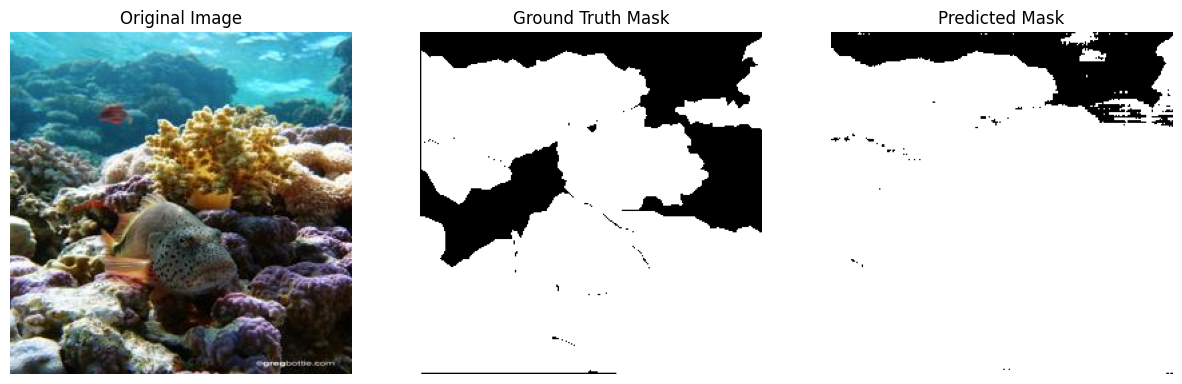

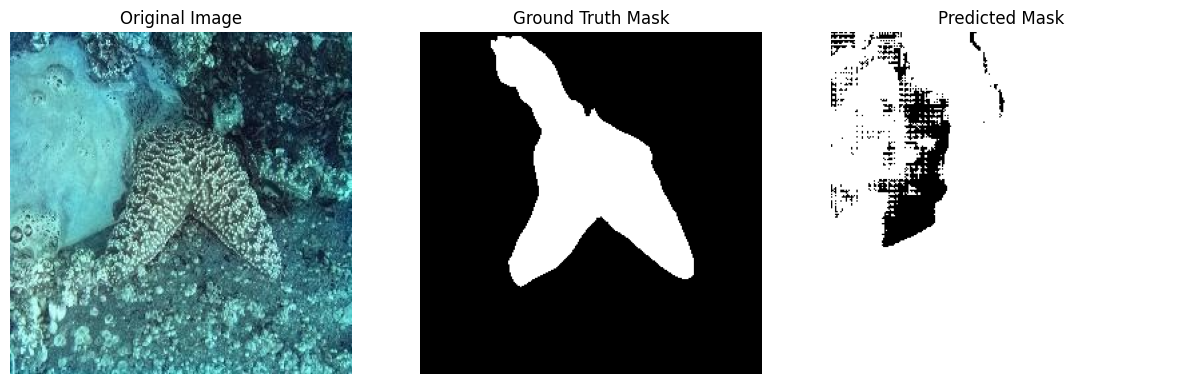

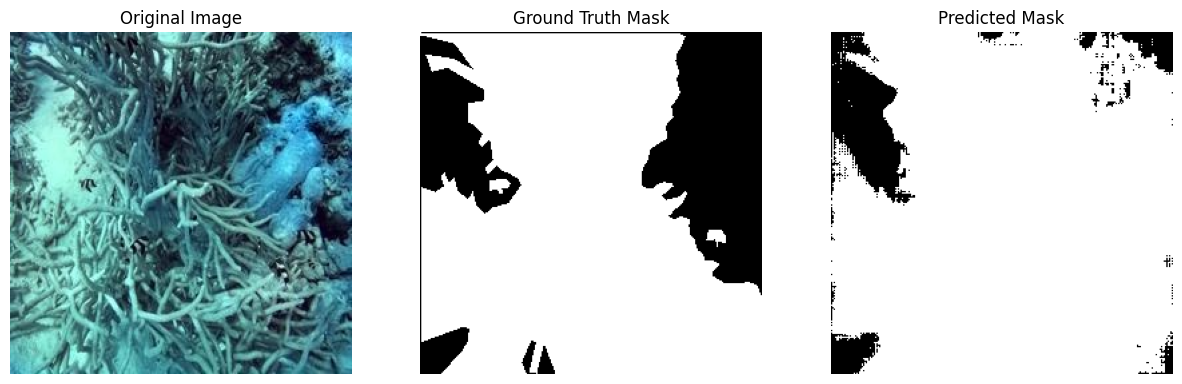

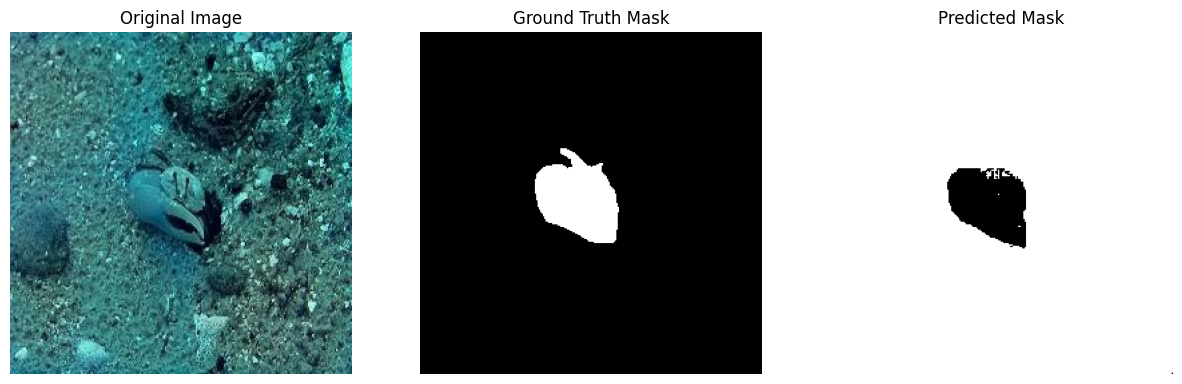

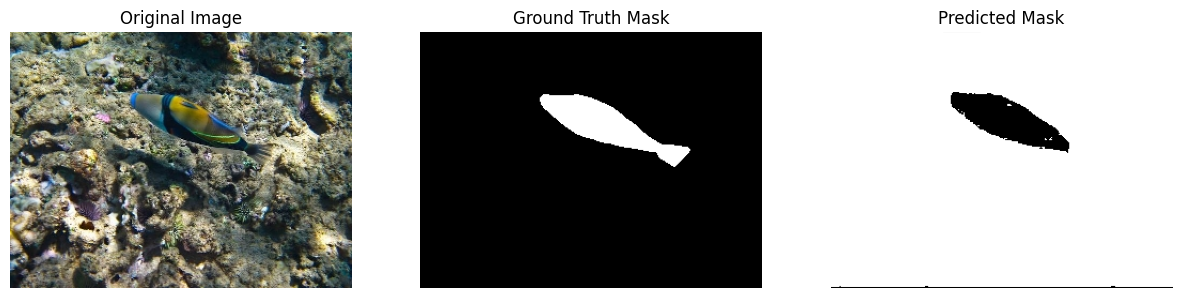

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.70s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

In [8]:
# Evaluation phase
print("\nStarting evaluation...")
sam.eval()  # Set model to evaluation mode
predictor = SamPredictor(sam)

with open(VAL_ANNOTATIONS_PATH) as f:
    coco_data = json.load(f)
coco_gt = COCO(VAL_ANNOTATIONS_PATH)
results = []

# Metrics storage
all_ious = []
all_gt_masks = []
all_pred_masks = []
visualization_samples = []
count = 0

for img_idx, img_info in enumerate(coco_data['images']):
    count += 1
    if count > 10:
        break
        
    img_id = img_info['id']
    img_path = os.path.join(VAL_IMAGES_PATH, img_info['file_name'])

    image = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    predictor.set_image(image_rgb)

    boxes = np.array([[0, 0, img_info['width'], img_info['height']]])
    masks, scores, _ = predictor.predict(box=boxes, multimask_output=True)

    gt_mask_combined = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

    ann_ids = coco_gt.getAnnIds(imgIds=img_id)
    gt_annotations = coco_gt.loadAnns(ann_ids)
    
    for annotation in gt_annotations:
        poly_coords = annotation['segmentation'][0]
        rr, cc = polygon(poly_coords[1::2], poly_coords[0::2], gt_mask_combined.shape)
        gt_mask_combined[rr, cc] = 1

    best_mask = None
    best_score = -1
    best_iou = -1

    for i in range(len(masks)):
        mask = masks[i]
        score = scores[i]
        if score > 0.5:
            current_iou = calculate_iou(gt_mask_combined, mask)
            if current_iou > best_iou:
                best_iou = current_iou
                best_mask = mask
                best_score = score

    if best_mask is not None:
        rle = maskUtils.encode(np.asfortranarray(best_mask))
        rle['counts'] = rle['counts'].decode('utf-8')
        
        results.append({
            'image_id': img_id,
            'category_id': 1,
            'segmentation': rle,
            'score': best_score,
            'area': np.sum(best_mask),
        })

        all_ious.append(best_iou)
        all_gt_masks.extend(gt_mask_combined.flatten())
        all_pred_masks.extend(best_mask.flatten())

        if len(visualization_samples) < 5:
            visualization_samples.append({
                'image': image_rgb,
                'gt_mask': gt_mask_combined,
                'pred_mask': best_mask
            })

# Calculate metrics
mean_iou = np.mean(all_ious)
accuracy = accuracy_score(all_gt_masks, all_pred_masks)
precision = precision_score(all_gt_masks, all_pred_masks)
recall = recall_score(all_gt_masks, all_pred_masks)

print("\nEvaluation Metrics:")
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

print("\nVisualizing 5 sample predictions:")
for sample in visualization_samples:
    visualize_sample(sample['image'], sample['gt_mask'], sample['pred_mask'])

with open('results.json', 'w') as f:
    json.dump(results, f, default=to_serializable)

coco_dt = coco_gt.loadRes('results.json')
coco_eval = COCOeval(coco_gt, coco_dt, 'segm')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()